In [1]:
import pandas as pd
import numpy as np
from  graphviz import Source
from scipy import misc
import matplotlib.pyplot as plt
import seaborn as sns

#### Importar dados para analise
Para iniciar a analise dos dados primeiro necessita-se
importar esse dados, os .csv encontrados abaixo são os dados disponibilizados
[aqui](https://archive.ics.uci.edu/ml/datasets/record+linkage+comparison+patterns).
Após carregar cada um dos dados .csv unimos em um unico frame do pandas.

In [2]:
dataframe = pd.DataFrame()
for x in range(1,11):
    dataframe_name = 'data/block_'+str(x)+'.csv'
    new_dataframe = pd.read_csv(dataframe_name)
    dataframe = pd.concat([dataframe,new_dataframe])

frame = dataframe

#### Exibir Frame
Exibir resultado do merge dos frames..

In [3]:
frame.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,?,1.0,?,1,1,1,1,0,True
1,39086,47614,1,?,1.0,?,1,1,1,1,1,True
2,70031,70237,1,?,1.0,?,1,1,1,1,1,True
3,84795,97439,1,?,1.0,?,1,1,1,1,1,True
4,36950,42116,1,?,1.0,1,1,1,1,1,1,True


In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    object
cmp_fname_c2    object
cmp_lname_c1    float64
cmp_lname_c2    object
cmp_sex         int64
cmp_bd          object
cmp_bm          object
cmp_by          object
cmp_plz         object
is_match        bool
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 531.8+ MB


É possível observar que os dados numéricos estão em formatos de string

#### Corrigindo tipos de dados

In [3]:
broken_columns = list(frame.columns[2:11])

for column in broken_columns:
    frame[column] = frame[column].apply(lambda x: np.NaN if x == '?' else x)
    frame[column] = frame[column].apply(lambda x: float(x) if type(x) == str else x)

In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    float64
cmp_fname_c2    float64
cmp_lname_c1    float64
cmp_lname_c2    float64
cmp_sex         int64
cmp_bd          float64
cmp_bm          float64
cmp_by          float64
cmp_plz         float64
is_match        bool
dtypes: bool(1), float64(8), int64(3)
memory usage: 531.8 MB


#### Verificando a existência de valores nulos

In [4]:
imp_values = frame.drop(['id_1','id_2','is_match'],axis=1)

In [8]:
melted_frame = pd.melt(imp_values.notnull())

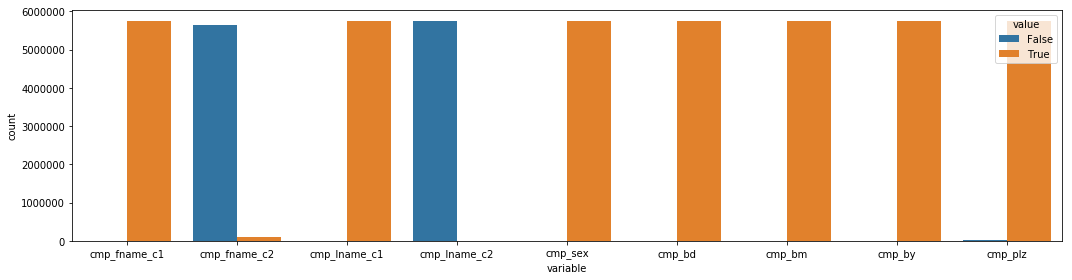

In [9]:
plt.figure(figsize=(15,4))
sns.countplot(melted_frame['variable'],hue=melted_frame['value'])
plt.tight_layout()

No gráfico acima as barras em azul representam o número de valores nulos de cada coluna

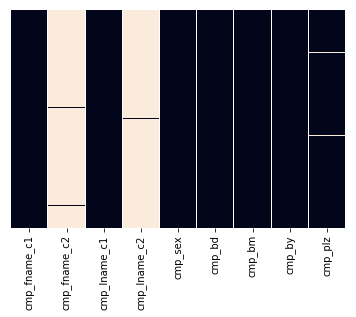

In [10]:
sns.heatmap(imp_values.isnull(),cbar=False,yticklabels=False)

Acima vemos outro gráfico que representa a quantidade de valores nulos de cada coluna. Nesse caso as partes claras
representam os valores faltantes

#### Removendo colunas vazias
Com a visualização dos graficos é possivel observar que as colunas cmp_fname_c2 e cmp_lname_c2, existem muitos dados faltantes, então ele serão desconsideradas a aplicação dos métodos e nas demais colunas onde existem dados faltantes serão preenchidas pelas medias dos valores dos dados;

Removendo colunas desnecessario para aplicar o modelo.

In [4]:
frame.drop(['id_1','id_2','cmp_fname_c2','cmp_lname_c2'],axis=1,inplace=True)

Aplicando as medias para os demais valores faltantes dos frames.

In [5]:
def preparer_data(frame):
    frame["cmp_fname_c1"] = frame["cmp_fname_c1"].replace(np.NaN,0.000235404896421846)
    frame["cmp_lname_c1"] = frame["cmp_lname_c1"].replace(np.NaN,2.68694413843136e-05)
    frame["cmp_sex"] = frame["cmp_sex"].replace(np.NaN,0.5)
    frame["cmp_bd"] = frame["cmp_bd"].replace(np.NaN,0.032258064516129)
    frame["cmp_bm"] = frame["cmp_bm"].replace(np.NaN,0.0833333333333333)
    frame["cmp_by"] = frame["cmp_by"].replace(np.NaN, 0.00943396226415094)
    frame["cmp_plz"] = frame["cmp_plz"].replace(np.NaN, 0.000422654268808115)
    
    return frame

frame = preparer_data(frame)

#### Verificando a existência de valores nulos

In [7]:
frame.isnull().values.any()

False

Ainda para observar, se as demais features que irão realmente compor o modelo, iremos buscar a correlação entre elas,
casos duas features tenham correlação muito alta, deverão ser desconsideradas no modelo, pois elas basicamente estariam 
trazendo a mesma informação ao modelo.

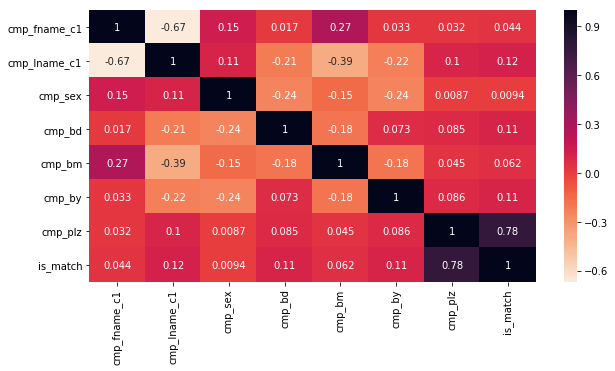

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(frame.corr(),annot=True,cmap=sns.cm.rocket_r)

Partindo da tabela de correlação podemos intenficar, que os dados estão bem desacoplados, sendo assim podemos utilizalos no nosso modelo.

In [15]:
frame.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,0.833333,1.0,1,1.0,1.0,1.0,0.0,True
1,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
2,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
3,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
4,1.000000,1.0,1,1.0,1.0,1.0,1.0,True


Após esse tramento dos dados, essas features acima serão as que vão incorporar o modelo.

#### Distribuição dos Dados

In [8]:
frame['is_match'].value_counts()

False    5728201
True       20931
Name: is_match, dtype: int64

É possível notar que o dataset se encontra desbalanceado, tendo em vista que quantidade de observações da classe `is_match = false` é quase 274 veses maior que a classe de `is_match = true`.

#### Separação dos dados

In [6]:
X = frame.drop('is_match',axis=1)
y = frame['is_match']

#### Balanceamento dos dados

In [16]:
from imblearn.under_sampling import NearMiss
from collections import Counter

In [13]:
nm = NearMiss(ratio='majority',version=1)

In [15]:
X_reshaped, y_reshaped = nm.fit_sample(X,y)

NameError: name 'Counter' is not defined

In [17]:
print('New data shape {}'.format(Counter(y_reshaped)))

New data shape Counter({False: 20931, True: 20931})


#### Near Miss

Near Miss é um método de under-sampling apresentado no artigo [kNN approach to unbalanced data distributions: a case study involving information extraction](http://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf), e foi utilizado por meio da biblioteca [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html). Esse método pode ser abordado de 3 formas, aqui utilizamos o NearMiss-1 para realizar o balanceamento dos dados.

* ##### NearMiss-1
    Em um contexto onde as observações possuem duas classes, verdadeiro e falso, e as observações falsas representam a grande maioria dos dados, o NearMiss-1 calcula a distância média entre a observação falsas e as observações verdadeiras, e seleciona as obsevações falsas que obtiveram o menor valor.
    
     ![nearmiss2|5x5](http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_nearmiss_0011.png)
    

*imagem retirada da documentação da biblioteca balanced-learn*


#### KNN

KNN é um método de machine learning supervisionado. Métodos supervisionados são métodos que precisam ser treinados com observações já classificadas. Com base nessas observações o KNN calcula o número de vizinhos de uma observação desconhecida. Com esse conjunto de vizinhos é calculada a probabilidade condicional dessa observação pertencer a alguma das classes. No sklearn a classe que possuir o maior número de visinhos para aquela observação será designada como a classe da observação desconhecida.



In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
knn = KNeighborsClassifier()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.33, random_state=42)

In [22]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
predictions = knn.predict(X_test)

In [24]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      6942
       True       1.00      1.00      1.00      6873

avg / total       1.00      1.00      1.00     13815



In [25]:
print(confusion_matrix(y_test,predictions))

[[6931   11]
 [  10 6863]]


#### RandomUnderSampler

In [15]:
from imblearn.under_sampling import RandomUnderSampler

In [2]:
rus = RandomUnderSampler()

In [14]:
X_reshaped, y_reshaped = rus.fit_sample(X,y)
print('New data shape {}'.format(Counter(y_reshaped)))

New data shape Counter({False: 20931, True: 20931})


#### KNN

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.33, random_state=42)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      6942
       True       1.00      1.00      1.00      6873

avg / total       1.00      1.00      1.00     13815

[[6937    5]
 [   2 6871]]
